In [ ]:
import pandas as pd
import numpy as np
import data_prep as prep
import matplotlib.pyplot as plt
import hyperparameter_tuning as ht
import evaluate_model as eval
import model_BiLSTMCRF as mod
import train_val_model as tv
import json
import os
import sys
import optuna
import glob
import torch
import importlib
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [332]:
# nb_classes can be set either to 2 for binary classification, or to 3 for "BIO"
nb_classes = 2

In [333]:
n = 1
Mode = "FOLDER"

# file_path = "full_val_data.jsonl"
file_path = "mushroom.de_val.v2.jsonl"
folder_path = "data/val/"
absolute_path = os.path.abspath(file_path)
absolute_folder_path = os.path.abspath(folder_path)

data = []

ENTRY_FILTER = None

def fix_encoding(text):
    try:
        temptext = text.replace("\u0120", "")
        return temptext.encode('latin1').decode('utf-8')
    except (UnicodeEncodeError, UnicodeDecodeError):
        return text

if Mode == "FOLDER":
    jsonl_files = glob.glob(os.path.join(absolute_folder_path, "*.jsonl"))
    for file_path in jsonl_files:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                line_parsed = json.loads(line)
                if ENTRY_FILTER is None or line_parsed['id'] == ENTRY_FILTER:
                    data.append(line_parsed)
else:
    # Read the JSONL file line by line
    with open(absolute_path, 'r', encoding='utf-8') as file:
        for line in file:
            line_parsed = json.loads(line)
            if ENTRY_FILTER is None or line_parsed['id'] == ENTRY_FILTER:
                data.append(line_parsed)

### Data processing

In [334]:
df = pd.DataFrame(data)

ngram_pairs = pd.concat([prep.prepare_data_for_random_forest_classifier(row, n) for _, row in df.iterrows()], ignore_index=True)

empty_rows = ngram_pairs[ngram_pairs['ngram_logits'].apply(len) == 0]
num_empty_rows = len(empty_rows)
print(f"{num_empty_rows} dropped due to logit extraction error from {len(ngram_pairs)} total rows")
combined_df = ngram_pairs[ngram_pairs['ngram_logits'].apply(len) != 0]

empty_rows = ngram_pairs[ngram_pairs['ngram_logits'].apply(len) == 0]
df = ngram_pairs.copy()
label_encoder = LabelEncoder()
df["model_id_encoded"] = label_encoder.fit_transform(df["model_id"])
df["lang"] = label_encoder.fit_transform(df["lang"])

if nb_classes == 3:
    df["bio_tags"] = prep.create_bio_tags(df)
    df = df.drop("class", axis=1)
    bio_tag_to_idx = {"B": 0, "I": 1, "O": 2}
    df['encoded_bio_tags'] = df['bio_tags'].apply(lambda x: bio_tag_to_idx.get(x, 2))

df.head()

C:\Users\jbcel\AppData\Local\Temp\ipykernel_26892\2196326019.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ngram_pairs = pd.concat([prep.prepare_data_for_random_forest_classifier(row, n) for _, row in df.iterrows()], ignore_index=True)


3240 dropped due to logit extraction error from 38640 total rows


,id,model_id,lang,model_input,model_output_ngram,ngram_logits,start,end,class,cosine_similarity,token_overlap,mean_logits,entropy_logits,model_id_encoded
0,val-ar-1,arcee-ai/Arcee-Spark,0,كم عدد المقاطعات في جليقية؟,جليقة،,[],0.0,6.0,0.0,0.0,0.0,NaN,NaN,11
1,val-ar-1,arcee-ai/Arcee-Spark,0,كم عدد المقاطعات في جليقية؟,التي,[],7.0,11.0,0.0,0.0,0.0,NaN,NaN,11
2,val-ar-1,arcee-ai/Arcee-Spark,0,كم عدد المقاطعات في جليقية؟,تعرف,[],12.0,16.0,0.0,0.0,0.0,NaN,NaN,11
3,val-ar-1,arcee-ai/Arcee-Spark,0,كم عدد المقاطعات في جليقية؟,الآن,[],17.0,21.0,0.0,0.0,0.0,NaN,NaN,11
4,val-ar-1,arcee-ai/Arcee-Spark,0,كم عدد المقاطعات في جليقية؟,باسم,[],22.0,26.0,0.0,0.0,0.0,NaN,NaN,11


In [335]:
# Vocabulary size

all_tokens = []
for index, row in df.iterrows():
    tokens = row['model_output_ngram'].split()
    all_tokens.extend(tokens)

vocabulary = set(all_tokens)
vocab_size = len(vocabulary) + 2  # +2 for padding and unknown tokens
print(f"Vocabulary size: {vocab_size}")

token_to_index = {token: index for index, token in enumerate(vocabulary)}
token_to_index["<PAD>"] = vocab_size - 2  # Padding token
token_to_index["<UNK>"] = vocab_size - 1  # Unknown token

df["token_indices"] = df["model_output_ngram"].apply(
    lambda text: token_to_index.get(text, token_to_index["<UNK>"])
)

Vocabulary size: 9465


In [336]:
unique_ids = df["id"].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)
train_data = df[df['id'].isin(train_ids)]
test_data = df[df['id'].isin(test_ids)]

feature_names = ["mean_logits", "entropy_logits", "cosine_similarity", "model_id_encoded", "token_overlap", "lang", "token_indices"]

X_train = train_data[feature_names].values
X_test = test_data[feature_names].values
if nb_classes == 3:
    y_train = train_data['encoded_bio_tags'].values
    y_test = test_data['encoded_bio_tags'].values
elif nb_classes == 2:
    y_train = train_data['class'].values
    y_test = test_data['class'].values

X_train_grouped = train_data.groupby('id')[feature_names].apply(lambda x: x.values.tolist()).values
X_test_grouped = test_data.groupby('id')[feature_names].apply(lambda x: x.values.tolist()).values
if nb_classes == 3:
    y_train_grouped = train_data.groupby('id')['encoded_bio_tags'].apply(lambda x: x.tolist()).values
    y_test_grouped = test_data.groupby('id')['encoded_bio_tags'].apply(lambda x: x.tolist()).values
elif nb_classes == 2:
    y_train_grouped = train_data.groupby('id')['class'].apply(lambda x: x.tolist()).values
    y_test_grouped = test_data.groupby('id')['class'].apply(lambda x: x.tolist()).values

In [337]:
max_seq_len = max(max(len(sentence) for sentence in X_train_grouped), max(len(sentence) for sentence in X_test_grouped))

padded_features = [prep.pad_sequence_features(sentence, max_seq_len, token_to_index["<PAD>"]) for sentence in X_train_grouped]
padded_labels = [prep.pad_sequence_labels(sentence, max_seq_len, token_to_index["<PAD>"]) for sentence in y_train_grouped]

padded_features = np.array(padded_features, dtype=float)
padded_labels = np.nan_to_num(padded_labels, nan=token_to_index["<PAD>"])
padded_labels = np.array(padded_labels, dtype=int)

In [338]:
X_train, X_val, y_train, y_val = train_test_split(padded_features, padded_labels, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_train_tokens = X_train_tensor[:, :, 6].long()
X_train_additional_features = X_train_tensor[:, :, 0:6]
X_val_tokens = X_val_tensor[:, :, 6].long()
X_val_additional_features = X_val_tensor[:, :, 0:6]
X_train_additional_features = torch.nan_to_num(X_train_additional_features, nan=0.0) # RELEVANT?
X_val_additional_features = torch.nan_to_num(X_val_additional_features, nan=0.0)

train_data = TensorDataset(X_train_tokens, X_train_additional_features, y_train_tensor)
val_data = TensorDataset(X_val_tokens, X_val_additional_features, y_val_tensor)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

In [339]:
padded_features_test = [
    prep.pad_sequence_features(sentence, max_seq_len, token_to_index["<PAD>"]) for sentence in X_test_grouped
]
padded_labels_test = [
    prep.pad_sequence_labels(sentence, max_seq_len, token_to_index["<PAD>"]) for sentence in y_test_grouped
]

padded_features_test = np.array(padded_features_test, dtype=float)
padded_labels_test = np.nan_to_num(padded_labels_test, nan=token_to_index["<PAD>"])
padded_labels_test = np.array(padded_labels_test, dtype=int)

X_test_tensor = torch.tensor(padded_features_test, dtype=torch.float32)
y_test_tensor = torch.tensor(padded_labels_test, dtype=torch.long)

X_test_tokens = X_test_tensor[:, :, 6].long() 
X_test_additional_features = X_test_tensor[:, :, 0:6]
X_test_additional_features = torch.nan_to_num(X_test_additional_features, nan=0.0)

test_data = TensorDataset(X_test_tokens, X_test_additional_features, y_test_tensor)

### Definition of the model + training and validation loop

The architecture of the model is defined in the file **model_BiLSTMCRF.py**, the training and validation loops in **train_val_model.py**.

### Hyperparameter tuning

In [342]:
if nb_classes == 2:
    output_dim = 2
elif nb_classes == 3:
    output_dim = 3
additional_feature_dim = 6
padding_idx = token_to_index["<PAD>"]

# Hyperparameter optimization
def objective_with_args(trial):
    return ht.objective(
        trial=trial,
        vocab_size=vocab_size,
        output_dim=output_dim,
        padding_idx=padding_idx,
        additional_feature_dim=additional_feature_dim,
        train_data=train_data,
        val_data=val_data,
        test_data=test_data,
    )

# study = optuna.create_study(direction="maximize")
# study.optimize(objective_with_args, n_trials=10)

### Training of the model

In [404]:
best_params = {'hidden_dim': 128, 'embedding_dim': 250, 'learning_rate': 0.005, 'batch_size': 8}
#with bio: learning_rate: 0.00385

# Final training and evaluation
train_loader, val_loader, test_loader = prep.create_data_loaders(train_data, val_data, test_data, batch_size=best_params["batch_size"])

final_model = mod.BiLSTM_CRF_Model(
    vocab_size=vocab_size,
    embedding_dim=best_params["embedding_dim"],
    hidden_dim=best_params["hidden_dim"],
    output_dim=output_dim,
    padding_idx=padding_idx,
    additional_feature_dim=additional_feature_dim
)
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params["learning_rate"], weight_decay=1e-5)

best_val_loss_overall = float('inf')
best_model_state_overall = None

train_losses, val_losses, val_predictions, val_true_labels, best_model_state = tv.train_model_bilstm_crf(
    final_model, train_loader, val_loader, final_optimizer, epochs=5)

final_model.load_state_dict(best_model_state)

Epoch 1/10, Train Loss: 402.2253, Validation Loss: 274.1224
Epoch 2/10, Train Loss: 250.1766, Validation Loss: 264.9991
Epoch 3/10, Train Loss: 137.8997, Validation Loss: 319.3131
Epoch 4/10, Train Loss: 82.4029, Validation Loss: 249.7028
Epoch 5/10, Train Loss: 40.7785, Validation Loss: 340.6506
Epoch 6/10, Train Loss: 21.3819, Validation Loss: 360.9944
Epoch 7/10, Train Loss: 11.2384, Validation Loss: 362.9620
Epoch 8/10, Train Loss: 5.8747, Validation Loss: 359.7111
Epoch 9/10, Train Loss: 3.9119, Validation Loss: 416.1263
Epoch 10/10, Train Loss: 2.7862, Validation Loss: 402.8263


<All keys matched successfully>

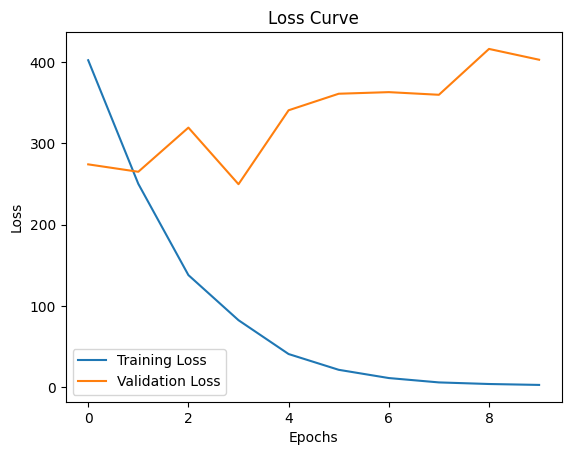

In [405]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

### Evaluation of the model

#### Classification metrics: precision, recall, f1-score...

In [406]:
# /!\ CRF does not return probabilities/soft labels
avg_loss, all_predictions, true_labels = eval.evaluate_model_bilstm_crf2(final_model, test_loader)

Accuracy: 75.86%

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81      5544
           1       0.75      0.60      0.67      3748

    accuracy                           0.76      9292
   macro avg       0.76      0.73      0.74      9292
weighted avg       0.76      0.76      0.75      9292



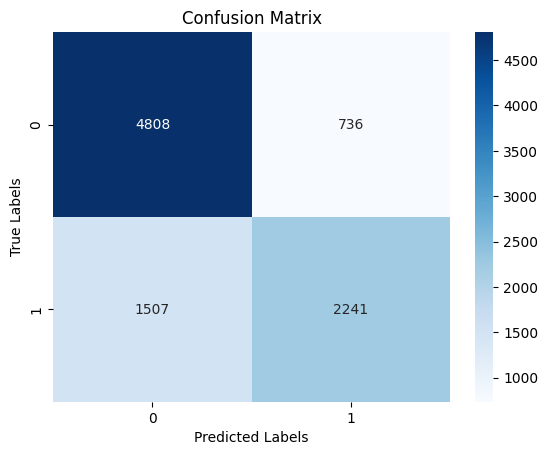

<Figure size 640x480 with 0 Axes>

In [407]:
import seaborn as sns

if nb_classes == 2:
    cm_bilstm = confusion_matrix(true_labels, all_predictions)
    sns.heatmap(cm_bilstm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1"], yticklabels=["0","1"])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    plt.savefig("conf_matrix_en.png")
if nb_classes == 3:
    cm_bilstm = confusion_matrix(true_labels, all_predictions)
    sns.heatmap(cm_bilstm, annot=True, fmt='d', cmap='Blues', xticklabels=["B","I","O"], yticklabels=["B","I","O"])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    plt.savefig("conf_matrix_en.png")

### Data processing of the results

In [411]:
def group_labels_by_sentence(hard_labels, seq_lens):
    grouped_hard_labels = []
    grouped_true_labels = []
    
    start_idx = 0  # Start index for slicing
    for seq_len in seq_lens:
        grouped_hard_labels.append(hard_labels[start_idx:start_idx + seq_len])
        grouped_true_labels.append(true_labels[start_idx:start_idx + seq_len])
        
        start_idx += seq_len
    
    return grouped_hard_labels, grouped_true_labels

In [409]:
if nb_classes == 2:
    grouped_data = (
        df.groupby("id")
        .agg(
            model_output_ngram=("model_output_ngram", list),
            start=("start", list),
            end=("end", list),
            label=("class", list),
        )
        .reset_index()
    )
elif nb_classes == 3:
    grouped_data = (
        df.groupby("id")
        .agg(
            model_output_ngram=("model_output_ngram", list),
            start=("start", list),
            end=("end", list),
            label=("encoded_bio_tags", list),
        )
        .reset_index()
    )

print(grouped_data)

            id                                 model_output_ngram  \
0     val-ar-1  [جليقة،, التي, تعرف, الآن, باسم, تتألف, من, مق...   
1    val-ar-10  [بدأ, مشروع, "ماكنتوش", (Macintosh), من, قبل, ...   
2    val-ar-11  [كان, الكَرْمِلين, في, الروسِية, القديمة, يُست...   
3    val-ar-12  [بروس, شتيرلينج, حصل, على, جوائز, هوگو, في, عا...   
4    val-ar-13  [زوجة, "جوني, الكاش", الثانية, كانت, بيلي, هيل...   
..         ...                                                ...   
494  val-zh-50  [1., 2., :, 皇家马德里（Real, Madrid）：2009年, 210年, 2...   
495   val-zh-6  [克里姆斯林宮（Kreml）是俄罗斯首都莫斯科市中心的一座历史悠久的建筑群，它是俄罗斯的象征...   
496   val-zh-7  [布鲁, 特林的成就和荣誉包括, ，他获得, 他还获得了许多其他奖项，包, 。, 的, 20...   
497   val-zh-8  [加拿大三角州市（Delta）位于不列颠哥伦比亚省南部，与以下几个市、镇和社区相邻或相望着：...   
498   val-zh-9  [苏, 珊, 梅, 耶, 家, 里, 最, 初, 的, 成, 员, 有, ：, 苏, 新, ...   

                                                 start  \
0    [0.0, 7.0, 12.0, 17.0, 22.0, 43.0, 49.0, 55.0,...   
1    [0.0, 4.0, 10.0, 20.0, 32.0, 35.0, 61.0, 39.0,... 

In [412]:
seq_lens = []
sorted_test_ids = []
for idx, row in grouped_data.iterrows():
    if row['id'] in test_ids:
        sorted_test_ids.append(row["id"])
        seq_lens.append(len(row["model_output_ngram"]))

grouped_hard_labels, grouped_true_labels = group_labels_by_sentence(
    all_predictions, seq_lens
)

In [413]:
result = []

for idx, row in grouped_data.iterrows():
    i = 0
    if row["id"] in sorted_test_ids:
        sentence_id = row["id"]
        ngrams = row["model_output_ngram"]
        starts = row["start"]
        ends = row["end"]
        true_labels = row["label"]

        # Extract predicted labels for the current sentence
        predicted_labels = grouped_hard_labels[sorted_test_ids.index(row["id"])]

        for ngram, start, end, true_class, predicted_class in zip(ngrams, starts, ends, true_labels, predicted_labels):
            if nb_classes == 2:
                transformed_true_class = true_class
                transformed_predicted_class = predicted_class
            elif nb_classes == 3:
                transformed_true_class = 0 if true_class == 2 else 1
                transformed_predicted_class = 0 if predicted_class == 2 else 1

            result.append({
                "id": sentence_id,
                "model_output_ngram": ngram,
                "start": start,
                "end": end,
                "true_class": transformed_true_class,
                "predicted_class": transformed_predicted_class
            })

import json
with open("output_binary.jsonl", "w", encoding="utf-8") as f:
    for entry in result:
        f.write(json.dumps(entry, ensure_ascii=False) + "\n")

In [414]:
import scoring_functions as scor

file_path = "output_binary.jsonl"

languages = ['de', 'ar', 'en', 'es', 'fi', 'fr', 'hi', 'it', 'sv', 'zh']

results_list = []

for language in languages:
    truth_path = f"data/val/mushroom.{language}-val.v2.jsonl"
    language_results = [result for result in scor.process_json_lines(file_path) if language in result.id]
    filtered_truth = scor.filter_truth_by_prediction_ids(truth_path, language_results)

    baseline_results = scor.create_random_baseline_instances(filtered_truth)

    if len(filtered_truth) == 0:
        print(f"skipping {language} due to empty truth set")
        continue

    # Get scores
    baseline_bilstm_score = scor.score_result(filtered_truth, language_results)
    baseline_random_score = scor.score_result(filtered_truth, baseline_results)

    # Append results for each language to the list
    results_list.append({
        'Language': language,
        'entrys': len(language_results),
        'Baseline_BiLSTM_CRF_IoU': baseline_bilstm_score['IoU'],
        #'Baseline_RF_Cor': baseline_rf_score['Cor'],
        'Baseline_Random_IoU': baseline_random_score['IoU']
        #'Baseline_Random_Cor': baseline_random_score['Cor']
    })
# Create DataFrame from results
results_df = pd.DataFrame(results_list)
sorted_results_df = results_df.sort_values(by='Baseline_BiLSTM_CRF_IoU', ascending=False)
pd.set_option('display.max_columns', None)
# Print the DataFrame
print(sorted_results_df)

  Language  entrys  Baseline_BiLSTM_CRF_IoU  Baseline_Random_IoU
7       it       5                 0.663094             0.490253
8       sv      10                 0.625550             0.388564
9       zh      11                 0.625549             0.355251
6       hi       7                 0.617902             0.198713
0       de      16                 0.574661             0.316999
1       ar       6                 0.548645             0.328153
4       fi       6                 0.509189             0.396949
2       en       7                 0.417641             0.117798
5       fr       7                 0.390789             0.331738
3       es       4                 0.185841             0.093945
